# Runtime Preparation

Installing third-party libraries using pip

In [1]:
!pip install dipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 60.6 MB/s eta 0:00:00


Importing standard and third-party libraries required for the framework

In [2]:
# standard library imports 
import os
import sys
import random
import time
import glob

# third-party library imports 
import numpy as np
import nibabel as nib
from nibabel import processing
from scipy.ndimage import zoom
from dipy.align.reslice import reslice
from skimage.filters import threshold_otsu, threshold_local
from skimage.measure import label
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision.transforms import Compose, RandomRotation, RandomHorizontalFlip, RandomVerticalFlip, functional as TF
from torch.utils.data import DataLoader, Dataset

Checking PyTorch Version and whether CUDA is supported on the machine


In [3]:
print('Installed PyTorch Version : ' + torch.__version__)

if torch.cuda.device_count() == 1:
  print('CUDA is supported using GPU : ' + torch.cuda.get_device_name(0))
else:
  print('CUDA is not supported on this machine.')

Installed PyTorch Version : 2.0.0+cu118
CUDA is supported using GPU : NVIDIA A100-SXM4-40GB


# Data Pre-Processing

Downloading MR Images from the [IXI Dataset](https://brain-development.org/ixi-dataset/), including
- PD MR Images
- T2 Weighted MR Images


In [4]:
# download PD MRI data
!wget http://biomedic.doc.ic.ac.uk/brain-development/downloads/IXI/IXI-PD.tar -O pd_data.tar

# download T2 MRI data
!wget http://biomedic.doc.ic.ac.uk/brain-development/downloads/IXI/IXI-T2.tar -O t2_data.tar

--2023-04-27 17:33:40--  http://biomedic.doc.ic.ac.uk/brain-development/downloads/IXI/IXI-PD.tar
Resolving biomedic.doc.ic.ac.uk (biomedic.doc.ic.ac.uk)... 146.169.22.31
Connecting to biomedic.doc.ic.ac.uk (biomedic.doc.ic.ac.uk)|146.169.22.31|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://biomedic.doc.ic.ac.uk/brain-development/downloads/IXI/IXI-PD.tar [following]
--2023-04-27 17:33:42--  https://biomedic.doc.ic.ac.uk/brain-development/downloads/IXI/IXI-PD.tar
Connecting to biomedic.doc.ic.ac.uk (biomedic.doc.ic.ac.uk)|146.169.22.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4068966400 (3.8G) [application/x-tar]
Saving to: ‘pd_data.tar’

pd_data.tar         100%[===================>]   3.79G  14.3MB/s    in 4m 37s  

2023-04-27 17:38:20 (14.0 MB/s) - ‘pd_data.tar’ saved [4068966400/4068966400]

URL transformed to HTTPS due to an HSTS policy
--2023-04-27 17:38:21--  https://biomedic.doc.ic.ac.uk/brain-dev

Creating directories and extracting MRI scans to the specified directories

In [5]:
!mkdir dataset
!mkdir dataset/IXI_PD_MRI
!mkdir dataset/IXI_T2w_MRI
!mkdir log
!mkdir model
!mkdir output

!tar -xvf pd_data.tar -C "./dataset/IXI_PD_MRI"
!tar -xvf t2_data.tar -C "./dataset/IXI_T2w_MRI"

IXI002-Guys-0828-PD.nii.gz
IXI012-HH-1211-PD.nii.gz
IXI013-HH-1212-PD.nii.gz
IXI014-HH-1236-PD.nii.gz
IXI015-HH-1258-PD.nii.gz
IXI016-Guys-0697-PD.nii.gz
IXI017-Guys-0698-PD.nii.gz
IXI019-Guys-0702-PD.nii.gz
IXI020-Guys-0700-PD.nii.gz
IXI021-Guys-0703-PD.nii.gz
IXI022-Guys-0701-PD.nii.gz
IXI023-Guys-0699-PD.nii.gz
IXI024-Guys-0705-PD.nii.gz
IXI025-Guys-0852-PD.nii.gz
IXI026-Guys-0696-PD.nii.gz
IXI027-Guys-0710-PD.nii.gz
IXI028-Guys-1038-PD.nii.gz
IXI029-Guys-0829-PD.nii.gz
IXI030-Guys-0708-PD.nii.gz
IXI031-Guys-0797-PD.nii.gz
IXI033-HH-1259-PD.nii.gz
IXI034-HH-1260-PD.nii.gz
IXI035-IOP-0873-PD.nii.gz
IXI036-Guys-0736-PD.nii.gz
IXI037-Guys-0704-PD.nii.gz
IXI038-Guys-0729-PD.nii.gz
IXI039-HH-1261-PD.nii.gz
IXI040-Guys-0724-PD.nii.gz
IXI041-Guys-0706-PD.nii.gz
IXI042-Guys-0725-PD.nii.gz
IXI043-Guys-0714-PD.nii.gz
IXI044-Guys-0712-PD.nii.gz
IXI045-Guys-0713-PD.nii.gz
IXI046-Guys-0824-PD.nii.gz
IXI048-HH-1326-PD.nii.gz
IXI049-HH-1358-PD.nii.gz
IXI050-Guys-0711-PD.nii.gz
IXI051-HH-1328-PD.ni

# Data Visualization

In [6]:
def visualize_random_images(directory):
    """
    This function loads 5 random images from a directory, plots the middle slice of each image,
    and displays them as subplots in a figure.

    Parameters:
        directory (str): A string representing the directory path where the images are stored.

    Returns:
        None

    Raises:
        None
    """
    # Get all file names in the directory
    all_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    
    # Check if there are fewer than 5 files in the directory
    if len(all_files) < 5:
        print("There are fewer than 5 files in the directory.")
        return
    
    # Choose 5 random file names from the directory
    random_files = random.sample(all_files, 5)

    # Create a figure with 5 subplots
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    
    # Load each random image and plot the middle slice
    for i, file in enumerate(random_files):
        file_path = os.path.join(directory, file)
        img = nib.load(file_path)
        img_data = img.get_fdata()
        slice_idx = img_data.shape[2] // 2
        axes[i].imshow(img_data[:, :, slice_idx].T, cmap='gray', origin='lower')
        axes[i].axis('off')

    # Show the plot
    plt.show()

Calling the visualize_random_images() function to visualize 5 random PD MRI Scans

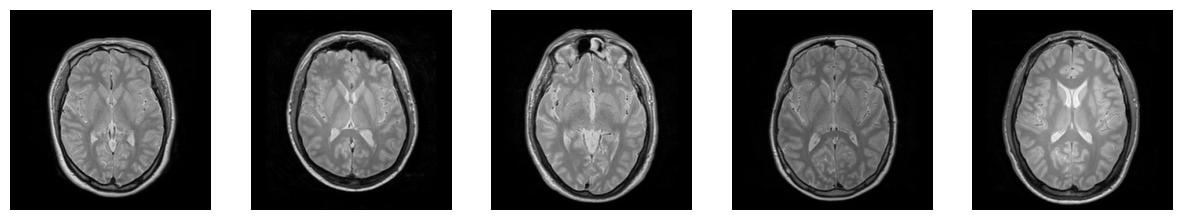

In [7]:
visualize_random_images('./dataset/IXI_PD_MRI')

Calling the visualize_random_images() function to visualize 5 random T2 weighted MRI Scans

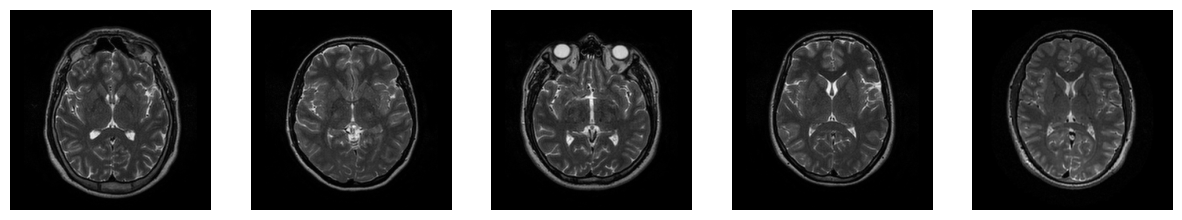

In [8]:
visualize_random_images('./dataset/IXI_T2w_MRI')

In [9]:
class ImagePairGenerator(Dataset):
    """
    This class generates a pair of normalized and resampled images at runtime for image registration tasks.

    Parameters:
        fixed_image_dir (str): A string representing the directory path containing fixed images.
        moving_image_dir (str): A string representing the directory path containing moving images.

    Returns:
        None

    Raises:
        None
    """
    def __init__(self, fixed_image_dir, moving_image_dir, target_size=(144, 144, 144)):
        self.fixed_image_dir = fixed_image_dir
        self.moving_image_dir = moving_image_dir
        self.target_size = target_size
        self.fixed_image_paths = sorted(glob.glob(os.path.join(fixed_image_dir, '*.nii.gz')))
        self.moving_image_paths = sorted(glob.glob(os.path.join(moving_image_dir, '*.nii.gz')))

    def __len__(self):
        """
        Returns the number of image pairs in the dataset.

        Parameters:
            None

        Returns:
            int: The number of image pairs in the dataset.

        Raises:
            None
        """
        return len(self.fixed_image_paths)

    def _load_images(self, fixed_image_path, moving_image_path):
        """
        Loads and resamples a fixed and moving image to the desired target size.

        Parameters:
            fixed_image_path (str): A string representing the path of the fixed image.
            moving_image_path (str): A string representing the path of the moving image.

        Returns:
            tuple: A tuple containing the normalized and resampled fixed and moving images as tensors.

        Raises:
            None
        """
        fixed_image = nib.load(fixed_image_path)
        moving_image = nib.load(moving_image_path)

        fixed_image_data = fixed_image.get_fdata()
        moving_image_data = moving_image.get_fdata()

        fixed_resampling_factors = [t / f for t, f in zip(self.target_size, fixed_image_data.shape)]
        moving_resampling_factors = [t / m for t, m in zip(self.target_size, moving_image_data.shape)]

        fixed_image_data = zoom(fixed_image_data, fixed_resampling_factors, order=1)
        moving_image_data = zoom(moving_image_data, moving_resampling_factors, order=1)

        fixed_image_normalized = (fixed_image_data - fixed_image_data.min()) / (fixed_image_data.max() - fixed_image_data.min() + 1e-8)
        moving_image_normalized = (moving_image_data - moving_image_data.min()) / (moving_image_data.max() - moving_image_data.min() + 1e-8)

        fixed_image_tensor = torch.tensor(fixed_image_normalized, dtype=torch.float32).unsqueeze(0)
        moving_image_tensor = torch.tensor(moving_image_normalized, dtype=torch.float32).unsqueeze(0)
        return fixed_image_tensor, moving_image_tensor

    def __getitem__(self, index):
        """
        Returns a pair of normalized and resampled fixed and moving images and their respective paths.

        Parameters:
            index (int): An integer representing the index of the image pair.

        Returns:
            tuple: A tuple containing the normalized and resampled fixed and moving images as tensors,
            and their respective file paths.

        Raises:
            None
        """
        fixed_image_path = self.fixed_image_paths[index]
        moving_image_path = self.moving_image_paths[index]
        fixed_image_tensor, moving_image_tensor = self._load_images(fixed_image_path, moving_image_path)
        return fixed_image_tensor, moving_image_tensor, fixed_image_path, moving_image_path

In [10]:
class LaplacianPyramid3D(nn.Module):
    """
    This class implements a 3D Laplacian pyramid for image processing.

    Parameters:
        levels (int): An integer representing the number of pyramid levels.

    Returns:
        None

    Raises:
        None
    """
    def __init__(self, levels):
        super(LaplacianPyramid3D, self).__init__()
        self.levels = levels
        self.gauss_pyramid = nn.ModuleList([nn.AvgPool3d(2, 2) for _ in range(levels)])

    def forward(self, img):
        """
        Builds a 3D Laplacian pyramid from an input tensor.

        Parameters:
            img (tensor): A tensor representing the input image.

        Returns:
            list: A list of tensors representing the levels of the Laplacian pyramid.

        Raises:
            None
        """
        pyramid = []
        current = img
        for level in range(self.levels):
            downsampled = self.gauss_pyramid[level](current)
            upsampled = nn.functional.interpolate(downsampled, size=current.shape[2:], mode='trilinear', align_corners=True)

            # Pad the upsampled tensor if needed
            pad_dims = [0, 0, 0, 0, 0, 0]  # padding for (left, right, top, bottom, front, back)
            for i in range(2, 5):
                if upsampled.size(i) < current.size(i):
                    pad_dims[2 * (5 - i)] = 1

            if sum(pad_dims) > 0:
                upsampled = nn.functional.pad(upsampled, pad_dims)

            laplacian = current - upsampled
            pyramid.append(laplacian)
            current = downsampled
        pyramid.append(current)
        return pyramid

In [11]:
class UNet(nn.Module):
    """
    This class implements a 3D U-Net for image segmentation.

    Parameters:
        in_channels (int): An integer representing the number of input channels.
        out_channels (int): An integer representing the number of output channels.

    Returns:
        None

    Raises:
        None
    """ 
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv3d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.middle = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.decoder = nn.Sequential(
            nn.Conv3d(128 + 64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(64, out_channels, kernel_size=3, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        """
        Implements a forward pass through the U-Net architecture.

        Parameters:
            x (tensor): A tensor representing the input image.

        Returns:
            tensor: A tensor representing the output segmentation mask.

        Raises:
            None
        """
        x1 = self.encoder(x)
        x2 = F.max_pool3d(x1, kernel_size=2, stride=2)
        x3 = self.middle(x2)
        x4 = F.interpolate(x3, scale_factor=2, mode='trilinear', align_corners=True)
        x5 = torch.cat([x4, x1], dim=1)
        x6 = self.decoder(x5)
        return x6

In [12]:
class ImageRegistrationNet(nn.Module):
    """
    This class implements a deep learning model for image registration.

    Parameters:
        None

    Returns:
        None

    Raises:
        None
    """
    def __init__(self):
        super(ImageRegistrationNet, self).__init__()
        self.unet = UNet(in_channels=2, out_channels=3)

    def forward(self, fixed_image, moving_image):
        """
        Implements a forward pass through the image registration network.

        Parameters:
            fixed_image (tensor): A tensor representing the fixed image.
            moving_image (tensor): A tensor representing the moving image.

        Returns:
            tensor: A tensor representing the displacement field.

        Raises:
            None
        """
        x = torch.cat((fixed_image, moving_image), dim=1)
        displacement_field = self.unet(x)
        return displacement_field

In [13]:
def mse_loss(registered_image, fixed_image):
    """
    Computes the mean squared error loss between a registered image and a fixed image.

    Parameters:
        registered_image (tensor): A tensor representing the registered image.
        fixed_image (tensor): A tensor representing the fixed image.

    Returns:
        tensor: A tensor representing the mean squared error loss.

    Raises:
        None
    """
    return torch.mean((registered_image - fixed_image) ** 2)

In [14]:
def jacobian_determinant(displacement_field):
    """
    Computes the Jacobian determinant of the displacement field.

    Parameters:
        displacement_field (tensor): A tensor representing the displacement field.

    Returns:
        tensor: A tensor representing the Jacobian determinant of the displacement field.

    Raises:
        None
    """
    # Calculate the gradients of the displacement field
    grad_x = torch.gradient(displacement_field[:, 0, :, :, :], dim=(1, 2, 3))
    grad_y = torch.gradient(displacement_field[:, 1, :, :, :], dim=(1, 2, 3))
    grad_z = torch.gradient(displacement_field[:, 2, :, :, :], dim=(1, 2, 3))

    gradients = torch.stack([
        grad_x[0], grad_x[1], grad_x[2],
        grad_y[0], grad_y[1], grad_y[2],
        grad_z[0], grad_z[1], grad_z[2]
    ], dim=1)

    # Create the Jacobian matrix (3x3) for each voxel
    jacobian = gradients.permute(0, 2, 3, 4, 1).view(-1, 3, 3)

    # Compute the determinant of the Jacobian matrix for each voxel
    jacobian_det = torch.det(jacobian)
    jacobian_det = jacobian_det.view(displacement_field.shape[0], displacement_field.shape[2], displacement_field.shape[3], displacement_field.shape[4])

    return jacobian_det

In [15]:
def dice_coefficient(true_mask, pred_mask, eps=1e-8):
    """
    Computes the Dice coefficient between a true mask and a predicted mask.

    Parameters:
        true_mask (ndarray): A numpy array representing the true mask.
        pred_mask (ndarray): A numpy array representing the predicted mask.
        eps (float): A small number to avoid division by zero.

    Returns:
        float: The Dice coefficient between the true and predicted masks.

    Raises:
        None
    """
    true_mask = torch.from_numpy(true_mask).float()
    pred_mask = torch.from_numpy(pred_mask).float()

    intersection = torch.sum(true_mask * pred_mask)
    union = torch.sum(true_mask) + torch.sum(pred_mask)

    if torch.all(true_mask == 0) and torch.all(pred_mask == 0):
        return 1.0

    dice = (2.0 * intersection + eps) / (union + eps)
    return dice.item()

In [16]:
def create_binary_mask(image, threshold=None, method='otsu'):
    """
    Creates a binary mask from an input image using thresholding.

    Parameters:
        image (ndarray): A numpy array representing the input image.
        threshold (float): A threshold value for binarizing the image.
        method (str): A string indicating the method to use for thresholding.
            Valid options are ['otsu', 'percentile', 'adaptive'].

    Returns:
        ndarray: A numpy array representing the binary mask.

    Raises:
        ValueError: If an invalid thresholding method is specified.
    """
    if threshold is None:
        if method == 'otsu':
            threshold = threshold_otsu(image)
        elif method == 'percentile':
            threshold = np.percentile(image, 90)
        elif method == 'adaptive':
            block_size = 35
            threshold = threshold_local(image, block_size, offset=10)
        else:
            raise ValueError("Invalid thresholding method. Choose from ['otsu', 'percentile', 'adaptive']")

    binary_mask = image > threshold
    label_image = label(binary_mask)
    label_counts = np.bincount(label_image.flat)[1:]

    if len(label_counts) == 0:
        # No connected regions found, return an empty mask
        return np.zeros_like(image, dtype=np.float32)

    largest_label = np.argmax(label_counts) + 1
    binary_mask = label_image == largest_label
    return binary_mask.astype(np.float32)

In [17]:
def plot_loss_vs_iterations(loss_values):
    """
    Plots the loss values vs. the number of iterations.

    Parameters:
        loss_values (list): A list of loss values.

    Returns:
        None

    Raises:
        None
    """
    # Convert loss values to floats if they are Torch tensors
    loss_values = [float(loss.cpu().detach().numpy()) if isinstance(loss, torch.Tensor) else loss for loss in loss_values]

    # Create a list of iterations
    iterations = list(range(1, len(loss_values) + 1))

    # Plot the loss values vs. the iterations
    plt.figure(figsize=(10, 5))
    plt.plot(iterations, loss_values, marker='o')
    plt.xlabel('Iterations')
    plt.ylabel('Loss Values')
    plt.title('Loss Values vs Iterations')
    plt.grid()
    plt.show()

In [18]:
def plot_dice_vs_iterations(dice_values):
    """
    Plots the Dice coefficient vs. the number of iterations.

    Parameters:
        dice_values (list): A list of Dice coefficient values.

    Returns:
        None

    Raises:
        None
    """
    # Convert Dice coefficient values to floats if they are Torch tensors
    dice_values = [float(dice.cpu().detach().numpy()) if isinstance(dice, torch.Tensor) else dice for dice in dice_values]

    # Create a list of iterations
    iterations = list(range(1, len(dice_values) + 1))

    # Plot the Dice coefficient values vs. the iterations
    plt.figure(figsize=(10, 5))
    plt.plot(iterations, dice_values, marker='o')
    plt.xlabel('Iterations')
    plt.ylabel('Dice Coefficient')
    plt.title('Dice Coefficient vs Iterations')
    plt.grid()
    plt.show()

In [19]:
def plot_time_vs_iterations(time_values):
    """
    Plots the time vs. the number of iterations.

    Parameters:
        time_values (list): A list of time values.

    Returns:
        None

    Raises:
        None
    """
    # Convert time values to floats if they are Torch tensors
    time_values = [float(time.cpu().detach().numpy()) if isinstance(time, torch.Tensor) else time for time in time_values]
    
    # Create a list of iterations
    iterations = list(range(1, len(time_values) + 1))

    # Plot the time values vs. the iterations
    plt.figure(figsize=(10, 5))
    plt.plot(iterations, time_values, marker='o')
    plt.xlabel('Iterations')
    plt.ylabel('Time')
    plt.title('Time vs Iterations')
    plt.grid()
    plt.show()

In [20]:
def laplacian_pyramid_loss(prediction, target, levels, device):
    """
    Calculates the Laplacian pyramid loss between the predicted and target images.

    Parameters:
        prediction (torch.Tensor): The predicted image tensor.
        target (torch.Tensor): The target image tensor.
        levels (int): The number of levels in the Laplacian pyramid.
        device (torch.device): The device on which to perform the calculations.

    Returns:
        torch.Tensor: The Laplacian pyramid loss between the predicted and target images.

    Raises:
        None
    """
    # Create a Laplacian pyramid with the specified number of levels
    lp = LaplacianPyramid3D(levels)
    lp = lp.to(device)
    
    # Compute the Laplacian pyramids for the predicted and target images
    pred_pyramid = lp(prediction)
    target_pyramid = lp(target)

    # Compute the MSE loss between the Laplacian pyramid levels
    loss = 0
    for pred_level, target_level in zip(pred_pyramid, target_pyramid):
        loss += nn.functional.mse_loss(pred_level, target_level)

    return loss

In [21]:
def combined_loss(warped_image, fixed_image, levels, device, alpha=0.6, beta=0.4):
    laplacian_loss = laplacian_pyramid_loss(warped_image, fixed_image, levels, device)
    smooth_l1_loss = nn.functional.smooth_l1_loss(warped_image, fixed_image)
    
    combined = alpha * laplacian_loss + beta * smooth_l1_loss
    return combined

In [22]:
def train_model(model, image_pair_loader, optimizer, scheduler, device, num_epochs):
    """
    Train a given model for a certain number of epochs.

    Parameters
    ----------
    model : torch.nn.Module
        The model to be trained.
    image_pair_loader : torch.utils.data.DataLoader
        The DataLoader which loads pairs of images for training.
    optimizer : torch.optim.Optimizer
        The optimizer to be used for model training.
    scheduler : torch.optim.lr_scheduler._LRScheduler
        The learning rate scheduler.
    device : torch.device
        The device (cpu or gpu) where the data should be loaded.
    num_epochs : int
        The number of epochs for which the model should be trained.

    Returns
    -------
    model : torch.nn.Module
        The trained model.
    training_accuracy_avg : float
        The average training accuracy over all epochs.
    dice_avg : float
        The average Dice coefficient over all epochs.
    jacobian_avg : float
        The average Jacobian determinant over all epochs.
    loss_values : list
        The list of loss values at each step.
    dice_values : list
        The list of Dice coefficients at each step.
    time_values : list
        The list of time taken at each step.
    total_time : float
        The total time taken for training.
    """
    
    # Initialize empty lists to store loss, dice and time values at each step
    loss_values = []
    dice_values = []
    time_values = []

    # Initialize counters for total time, training accuracy, dice and jacobian
    total_time = 0
    training_accuracy_sum = 0
    dice_sum = 0
    jacobian_sum = 0

    # Initialize counter for valid epochs
    valid_epochs = 0

    # Number of levels for Laplacian pyramid loss
    levels = 5

    # Start training loop for each epoch
    for epoch in range(num_epochs):
        # Initialize counters for each epoch
        image_step = 1
        training_accuracy_epoch = 0
        dice_epoch = 0
        valid_steps = 0

        epoch_start_time = time.time() # Record start time of epoch

        # Load image pairs from the dataloader
        for fixed_image, moving_image, fixed_image_path, moving_image_path in image_pair_loader:
            pair_start_time = time.time() # Record start time of pair processing

            # Move images to the specified device
            fixed_image, moving_image = fixed_image.to(device), moving_image.to(device)

            # Check if the shapes of the fixed and moving images match
            if fixed_image.shape != moving_image.shape:
                print("Skipping image pair with mismatched dimensions")
                continue  # Skip this image pair and move on to the next one
            
            valid_epochs += 1
            valid_steps += 1

            # Create binary masks for the images
            fixed_image_mask = create_binary_mask(fixed_image.cpu().numpy()[0, 0])
            moving_image_mask = create_binary_mask(moving_image.cpu().numpy()[0, 0])

            # Clear gradients from the previous iteration
            optimizer.zero_grad()

            # Run the model and compute the displacement field
            displacement_field = model(fixed_image, moving_image)

            # Reshape and normalize the displacement field to create a grid
            grid = displacement_field.permute(0, 2, 3, 4, 1)
            grid = torch.stack([
                2 * grid[:, :, :, :, 0] / (grid.shape[1] - 1),  # Normalize x coordinates
                2 * grid[:, :, :, :, 1] / (grid.shape[2] - 1),  # Normalize y coordinates
                2 * grid[:, :, :, :, 2] / (grid.shape[3] - 1)   # Normalize z coordinates
            ], dim=-1)

            # Apply the displacement field to the moving image to align it with the fixed image
            warped_image = nn.functional.grid_sample(moving_image, grid, align_corners=True)

            # Create a binary mask for the registered image
            registered_image_mask = create_binary_mask(warped_image.detach().cpu().numpy()[0, 0])

            pair_end_time = time.time() # Record end time of pair processing
            pair_time = pair_end_time - pair_start_time # Calculate time taken to process the pair

            # Calculate training accuracy using Mean Squared Error (MSE) loss
            training_accuracy = mse_loss(warped_image, fixed_image).item()

            # Calculate Dice coefficient to measure overlap between fixed_image_mask and registered_image_mask
            dice = dice_coefficient(fixed_image_mask, registered_image_mask)

            # Calculate the determinant of the Jacobian of the displacement field
            jacobian_det = jacobian_determinant(displacement_field)

            # Calculate the Laplacian pyramid loss
            loss = laplacian_pyramid_loss(warped_image, fixed_image, levels, device)
            
            # Perform backpropagation
            loss.backward()
            
            # Update the weights
            optimizer.step()

            # Append the loss, dice and time values to the respective lists
            loss_values.append(loss)
            dice_values.append(dice)
            time_values.append(pair_time)

            # Update the training accuracy, dice, and jacobian sums
            training_accuracy_sum += training_accuracy
            training_accuracy_epoch += training_accuracy
            dice_sum += dice
            dice_epoch += dice
            jacobian_sum += jacobian_det.mean().item()

            # Update the learning rate based on the training accuracy
            scheduler.step(training_accuracy)

            epoch_time = time.time() - epoch_start_time # Calculate time taken for the epoch
            total_time += epoch_time # Update total time

            # Print training loss and dice coefficient for the current step
            sys.stdout.write("\r" + 'step "{0}" -> training loss "{1:.4f}" - dice coefficient "{2:.4f}"'.format(image_step, training_accuracy, dice))
            sys.stdout.flush()
            image_step += 1
        
        # Calculate average training accuracy and dice coefficient for the epoch
        training_accuracy_epoch = training_accuracy_epoch / valid_steps
        dice_epoch = dice_epoch / valid_steps

        # Print epoch summary
        print(f"\nEpoch [{epoch+1}/{num_epochs}], Training Accuracy (MSE): {training_accuracy_epoch:.4f}, Dice Coefficient: {dice_epoch:.4f}, Time elapsed: {epoch_time:.2f} seconds")
    
    # Calculate average training accuracy, dice coefficient, and jacobian determinant for all epochs
    training_accuracy_avg = training_accuracy_sum / valid_epochs
    dice_avg = dice_sum / valid_epochs
    jacobian_avg = jacobian_sum / valid_epochs

    # Return the trained model and the computed metrics
    return model, training_accuracy_avg, dice_avg, jacobian_avg, loss_values, dice_values, time_values, total_time

In [30]:
def test_model(model_path, test_image_pair_loader, device):
    """
    Evaluate a given model on a test dataset.

    Parameters
    ----------
    model_path : str
        Path to the saved model that needs to be evaluated.
    test_image_pair_loader : torch.utils.data.DataLoader
        DataLoader that loads pairs of images for testing.
    device : torch.device
        The device (cpu or gpu) where the data should be loaded.

    Returns
    -------
    mse_avg : float
        The average mean squared error (MSE) over all the samples in the test dataset.
    dice_avg : float
        The average Dice coefficient over all the samples in the test dataset.
    jacobian_avg : float
        The average Jacobian determinant over all the samples in the test dataset.
    avg_time : float
        The average time taken to process each sample in the test dataset.
    """

    # Load the saved model
    model = ImageRegistrationNet().to(device)
    model.load_state_dict(torch.load(model_path))
    
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to store performance metrics
    mse_sum = 0
    dice_sum = 0
    jacobian_sum = 0
    num_samples = 0
    test_limit = 50
    time_sum = 0
    total_time = 0

    # Ensure no gradients are calculated
    with torch.no_grad():
        while test_limit > 0:
            for fixed_image, moving_image, fixed_image_path, moving_image_path in test_image_pair_loader:
                # Move images to the specified device
                fixed_image, moving_image = fixed_image.to(device), moving_image.to(device)

                # Check if the shapes of the fixed and moving images match
                if fixed_image.shape != moving_image.shape:
                    print("Skipping image pair with mismatched dimensions")
                    continue  # Skip this image pair and move on to the next one

                # Create binary masks for the images
                fixed_image_mask = create_binary_mask(fixed_image.cpu().numpy()[0, 0])
                moving_image_mask = create_binary_mask(moving_image.cpu().numpy()[0, 0])

                start_time = time.time() # Record start time of pair processing

                # Apply the model to the image pair
                displacement_field = model(fixed_image, moving_image)

                # Apply the displacement field to the moving image to align it with the fixed image
                warped_image = nn.functional.grid_sample(moving_image, displacement_field.permute(0, 2, 3, 4, 1), align_corners=True)
                
                # Create a binary mask for the registered image
                registered_image_mask = create_binary_mask(warped_image.detach().cpu().numpy()[0, 0])

                # Calculate performance metrics
                mse = mse_loss(warped_image, fixed_image).item()
                dice = dice_coefficient(fixed_image_mask, registered_image_mask)
                jacobian_det = jacobian_determinant(displacement_field).mean().item()

                elapsed_time = time.time() - start_time # Calculate time taken for processing the pair
                total_time += elapsed_time

                # Accumulate performance metrics
                mse_sum += mse
                dice_sum += dice
                jacobian_sum += jacobian_det
                num_samples += 1
                time_sum += elapsed_time
                test_limit -= 1

                # Save the output images and displacement field
                output_dir = './output/'
                os.makedirs(output_dir, exist_ok=True)

                # Plot and save the fixed image, moving image, registered image
                plt.figure(figsize=(18, 6))
                plt.subplot(1, 3, 1)
                plt.imshow(fixed_image.cpu().numpy()[0, 0, :, :, fixed_image.shape[2] // 2], cmap='gray')
                plt.title('Fixed Image')
                plt.axis('off')
                
                plt.subplot(1, 3, 2)
                plt.imshow(moving_image.cpu().numpy()[0, 0, :, :, moving_image.shape[2] // 2], cmap='gray')
                plt.title('Moving Image')
                plt.axis('off')
                
                plt.subplot(1, 3, 3)
                plt.imshow(registered_image_mask[:, :, registered_image_mask.shape[2] // 2], cmap='gray')
                plt.title('Registered Image')
                plt.axis('off')

                # Save the final figure as an image
                plt.savefig(os.path.join(output_dir, f'registered_{num_samples}.png'))
                plt.close()

                print("image tested")
                break

    # Calculate average performance metrics
    mse_avg = mse_sum / num_samples
    dice_avg = dice_sum / num_samples
    jacobian_avg = jacobian_sum / num_samples
    avg_time = total_time / num_samples

    # Return the average performance metrics
    return mse_avg, dice_avg, jacobian_avg, avg_time

In [24]:
def main():
    """
    Main function to train the image registration model and save the trained model.
    """
    # The directories for fixed and moving images
    fixed_image_dir = './dataset/IXI_T2w_MRI'
    moving_image_dir = './dataset/IXI_PD_MRI'

    # Generate pairs of images using the ImagePairGenerator class
    image_pair_dataset = ImagePairGenerator(fixed_image_dir, moving_image_dir)
    
    # Load the dataset using DataLoader
    image_pair_loader = DataLoader(image_pair_dataset, batch_size=1, shuffle=True, num_workers=2)

    # Check for GPU availability and set the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Instantiate the model, set up loss function, and optimizer
    l2_reg_strength = 1e-4
    model = ImageRegistrationNet().to(device)

    # Adam optimizer with learning rate 1e-5 and L2 regularization strength 1e-4
    optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=l2_reg_strength)

    # Reduce learning rate when a metric has stopped improving with patience 10 and factor 0.1
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.1)

    # Train the model for specified number of epochs
    num_epochs = 10
    model, training_accuracy_avg, dice_avg, jacobian_avg, loss_values, dice_values, time_values, total_time = train_model(model, image_pair_loader, optimizer, scheduler, device, num_epochs)

    # Print final metrics after training
    print(f"Total time: {total_time:.2f} seconds, Training Accuracy (MSE) average: {training_accuracy_avg:.4f}, Dice Coefficient average: {dice_avg:.4f}, Jacobian determinant average: {jacobian_avg:.4f}")
    
    # Save the trained model
    torch.save(model.state_dict(), "./model/model.pth")

    # Plot loss, dice coefficient, and time per iteration
    plot_loss_vs_iterations(loss_values)
    plot_dice_vs_iterations(dice_values)
    plot_time_vs_iterations(time_values)

step "578" -> training loss "0.1436" - dice coefficient "0.4235"
Epoch [1/10], Training Accuracy (MSE): 0.1964, Dice Coefficient: 0.3034, Time elapsed: 361.69 seconds
step "578" -> training loss "0.1285" - dice coefficient "0.0023"
Epoch [2/10], Training Accuracy (MSE): 0.1964, Dice Coefficient: 0.3010, Time elapsed: 360.82 seconds
step "578" -> training loss "0.1314" - dice coefficient "0.0811"
Epoch [3/10], Training Accuracy (MSE): 0.1964, Dice Coefficient: 0.3016, Time elapsed: 361.30 seconds
step "578" -> training loss "0.1815" - dice coefficient "0.0130"
Epoch [4/10], Training Accuracy (MSE): 0.1964, Dice Coefficient: 0.3013, Time elapsed: 360.88 seconds
step "578" -> training loss "0.3597" - dice coefficient "0.7935"
Epoch [5/10], Training Accuracy (MSE): 0.1964, Dice Coefficient: 0.3012, Time elapsed: 360.68 seconds
step "578" -> training loss "0.4487" - dice coefficient "0.3320"
Epoch [6/10], Training Accuracy (MSE): 0.1964, Dice Coefficient: 0.3021, Time elapsed: 359.13 second

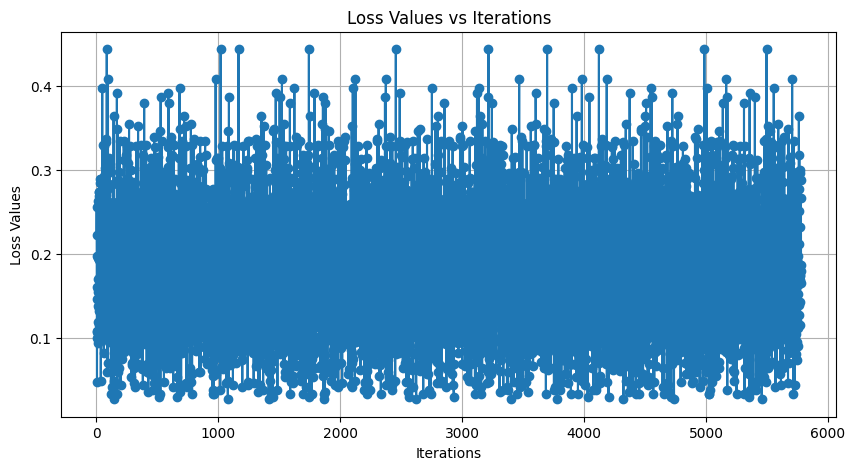

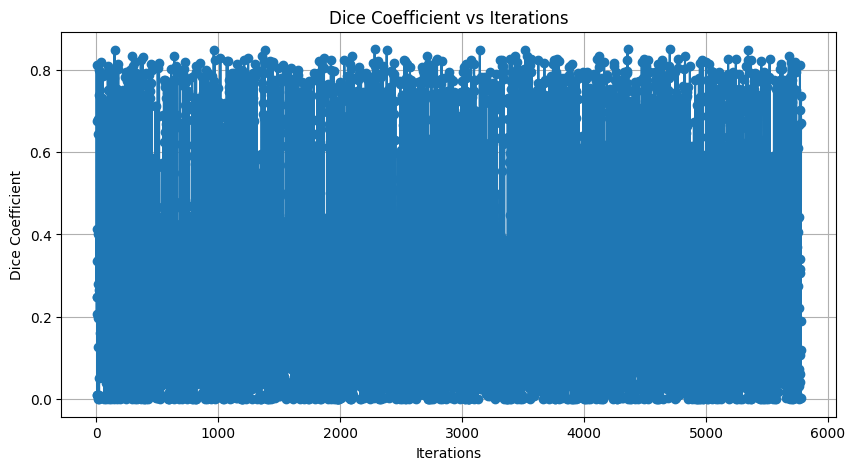

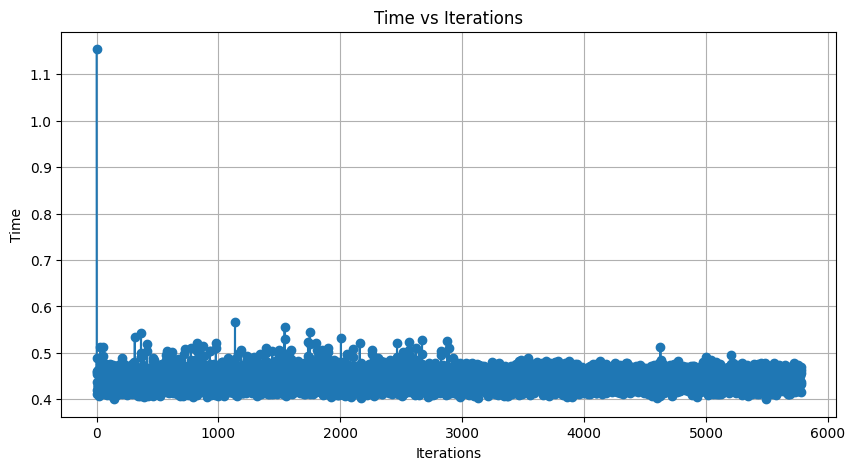

In [25]:
if __name__ == "__main__":
  main()

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

fixed_image_dir = './dataset/IXI_T2w_MRI'
moving_image_dir = './dataset/IXI_PD_MRI'
image_pair_dataset = ImagePairGenerator(fixed_image_dir, moving_image_dir)
test_image_pair_loader = DataLoader(image_pair_dataset, batch_size=1, shuffle=True, num_workers=2)
mse_avg, dice_avg, jacobian_avg, time_avg = test_model("./model/model.pth", test_image_pair_loader, device)

print(f"Test performance: MSE average: {mse_avg:.4f}, Dice Coefficient average: {dice_avg:.4f}, Jacobian determinant average: {jacobian_avg:.4f}, Average time: {time_avg:.4f}")


image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
image tested
Test performance: MSE average: 0.1850, Dice Coefficient average: 0.3439, Jacobian determinant average: 0.0000, Average time: 0.2285
